# Goal:   find range of ybeam (in mm) to reconstruct scattered intensities

drange_narrow = [0.0, 0.015]  # ybeam unit   mm for reconstruction of scattering intensity

#### ybeam positive towards sample depth

recspot, depth = rec.interpolate(drange_narrow)



In [1]:
#----------- global imports -----------
import os, sys
import matplotlib as mpl
import matplotlib.pylab as mplp
import numpy as np

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# lauetools path
path_to_lauetools = "/home/micha/LaueToolsPy3/LaueTools/"

print("Ajout de {} au PATH...".format(path_to_lauetools))

if path_to_lauetools not in sys.path:
    sys.path.insert(1, path_to_lauetools)


os.path.abspath(os.curdir)


Ajout de /home/micha/LaueToolsPy3/LaueTools/ au PATH...


'/home/micha/LaueToolsPy3/LaueTools/Daxm/scripts'

In [2]:
def fig_slider(vol, axis=2):
    
    vol = np.array(vol)
    
    widget = widgets.IntSlider(min=0, max=vol.shape[axis]-1, step=1, value=0)
    
    mplp.figure()
    
    if axis==0:
        img0 = vol[0, :, :]
    elif axis==1:
        img0 = vol[:, 0, :]
    else:
        img0 = vol[:, :, 0]
    
    
    ax = mplp.imshow(img0, vmin=np.min(vol), vmax=np.mean(vol) + 3.*np.std(vol), origin="bottom")
    mplp.colorbar()
    
    def update_img(idx):
        if axis==0:
            img = vol[idx, :, :]
        elif axis==1:
            img = vol[:, idx, :]
        else:
            img = vol[:, :, idx]
        ax.set_data(img)
        
    return interact(update_img, idx=widget)

In [3]:
#----------- daxm imports -----------
from LaueTools.Daxm.classes.scan import new_scan
from LaueTools.Daxm.classes.source import new_source
from LaueTools.Daxm.classes.calibration import CalibManager
from LaueTools.Daxm.classes.reconstruction import SpotReconstructor

import LaueTools.Daxm.classes.scan as LTdcs
LTdcs.__file__


-- OK! You are using python 3


ERROR:hdf5plugin:Cannot initialize filter fcidecomp: File not found


CalibManager in init of classes/calibration <class 'LaueTools.Daxm.classes.calibration.calib.CalibManager'>


'/home/micha/LaueToolsPy3/LaueTools/Daxm/classes/scan/__init__.py'

In [4]:
#----------- all directories -----------
analysis_dir = "/home/micha/LaueProjects/DAXMSept21/GeDAXM"
calib_dir = os.path.join(analysis_dir, "calibration")
recdir = os.path.join(analysis_dir, "reconstruction")
prefix = "GeDAXM"

#----------- all directories -----------
analysis_dir = "/media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002"
calib_dir = os.path.join(analysis_dir, "calibration")
recdir = os.path.join(analysis_dir, "reconstruction")
prefix = "ech13_daxm_0"

#----------- useful parameters for several wire scans arrangement-----------

#xgrid = np.arange(-0.007, 0.008, 0.001)
#ygrid = np.arange(-0.004, 0.016, 0.002)

# for single depthprofile 
xgrid = np.array([0.,])
ygrid = np.array([0.,])


y_calib = 0


## ZrO2 case

In [19]:
#----------- scan and calib -----------
#scan = new_scan(os.path.join(analysis_dir, prefix+".scan"))  # for mesh of wire scans
print('analysis_dir',analysis_dir)

#import LaueTools
#print('LT',LaueTools.__file__)


#scan = new_scan(os.path.join(analysis_dir, prefix+"_calib.scan"))
filescan = 'ech13_daxm_0.scan'

scan = new_scan(os.path.join(analysis_dir, filescan))

#scan.set_verbosity(False)

calib = CalibManager(prefix+".calib", yref=y_calib, directory=calib_dir)

#
sample = new_source("Ge", 0.05)   #Zr02 has the same ~ density as Ge

analysis_dir /media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002
scan_inp /media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002/ech13_daxm_0.scan
/media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002/ech13_daxm_0.scan 
#######     read .scan file  ############
scan_inp {'type': 'point', 'size': 0, 'skipFrame': 0, 'lineSubFolder': False, 'specFile': '/media/micha/LaCie/a322847_guillou_daxm/ech13/a322847_ech13.h5', 'scanNumber': 2, 'hdf5scanId': 'ech13_map2d3d_2', 'scanCmd': [-3.23, -2.78, 550, 1.0], 'CCDType': 'sCMOS', 'detCalib': '/media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_Ge13/scan_0023/calibGe111_camerastilldistorted.det', 'wire': ['W'], 'wireTrajAngle': 0.0, 'imageFolder': '/media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002', 'imagePrefix': 'ech13_daxm_0_', 'imageFirstIndex': 0, 'imageDigits': 4, 'imageOffset': 0.0, 'monitor': 'spec', 'monitorROI': [1024, 1024, -1, -1], 'monitorOffset': 10000, 'wires': [{'

[scan]    images in: /media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002
[scan]    named as: ech13_daxm_0_XXXX.tif
[scan]    found 551 images out of 551
[scan] - Loading monitor...
[scan] Ready to work.
self.filetype hdf5
end of StaticPointScan init
results compo in get_compo_from_mat() [['Ge', [0, 0.05], 5.323]]
arg in  initialize SecondarySource [['Ge', [0, 0.05], 5.323]]
arg <class 'list'>


## Ge case

In [5]:
#----------- scan and calib -----------
#scan = new_scan(os.path.join(analysis_dir, prefix+".scan"))  # for mesh of wire scans
print('analysis_dir',analysis_dir)

#import LaueTools
#print('LT',LaueTools.__file__)


scan = new_scan(os.path.join(analysis_dir, prefix+"_calib.scan"))

#scan.set_verbosity(False)

calib = CalibManager(prefix+".calib", yref=y_calib, directory=calib_dir)

#
sample = new_source("Ge", 0.02)


analysis_dir /media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002
scan_inp /media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002/ech13_daxm_0_calib.scan
/media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002/ech13_daxm_0_calib.scan 
#######     read .scan file  ############


FileNotFoundError: [Errno 2] No such file or directory: '/media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002/ech13_daxm_0_calib.scan'

## visualisation of Laue pattern. Wire shadowing

in plot_image in point.py


<IPython.core.display.Javascript object>


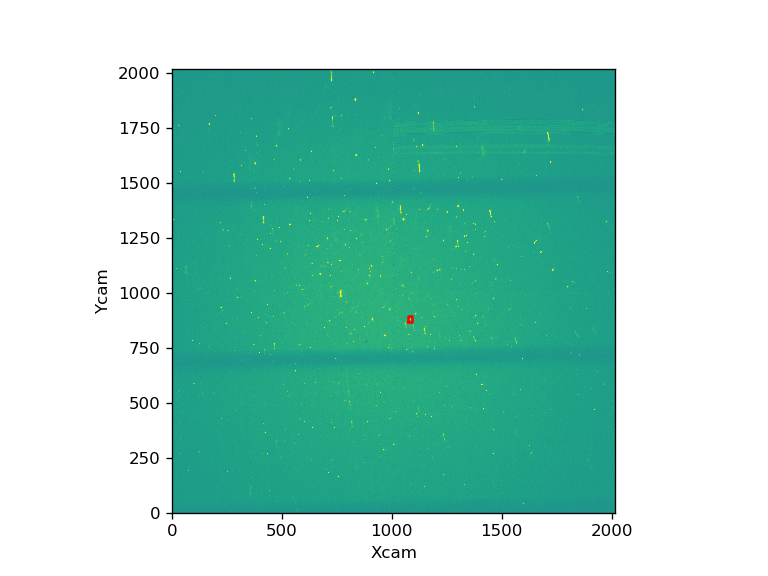

In [33]:
%matplotlib notebook

 # for mesh or line ( =  several point ) of wire scans
#scan.goto_centre()
#scan.goto(iy=0)

fig = scan.plot_image(20)

#----------- spot to analyse -----------
XYcam = [969, 806]  # 27 microns
XYcam = [1083, 880]  # 30 microns

#XYcam = [954, 806]  # fluo

halfboxsize = [8, 13]
E = 11

abscoeff = sample.calc_absorption(E)

# plot peak roi
mplp.plot([XYcam[0] - halfboxsize[0], XYcam[0] + halfboxsize[0],
           XYcam[0] + halfboxsize[0], XYcam[0] - halfboxsize[0],
           XYcam[0] - halfboxsize[0]],
          [XYcam[1] - halfboxsize[1], XYcam[1] - halfboxsize[1],
           XYcam[1] + halfboxsize[1], XYcam[1] + halfboxsize[1],
           XYcam[1] - halfboxsize[0]], 'r')


In [16]:
wmin, wmax = scan.wire_position[0],scan.wire_position[-1]

<IPython.core.display.Javascript object>


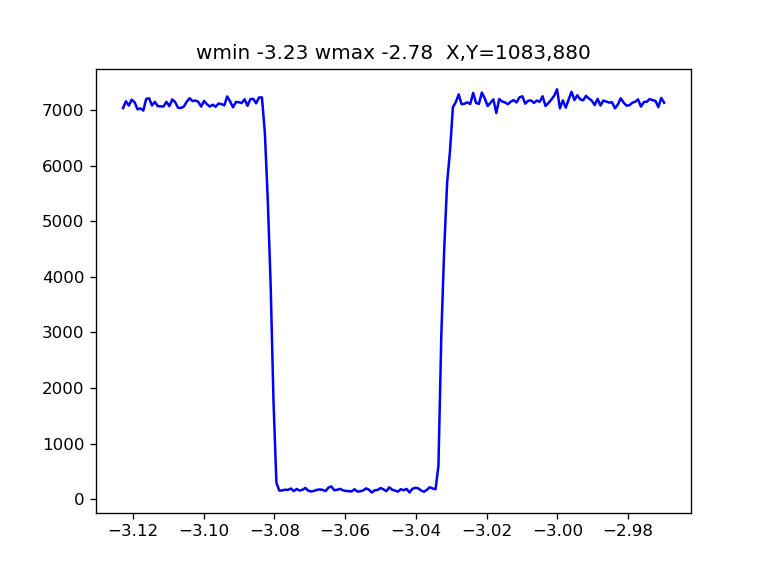

<IPython.core.display.Javascript object>


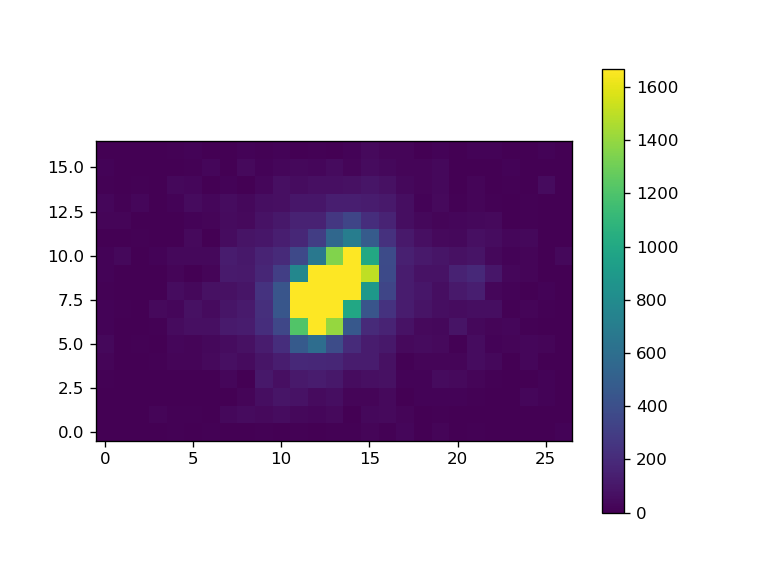

interactive(children=(IntSlider(value=0, description='idx', max=187), Output()), _dom_classes=('widget-interac…

<function __main__.fig_slider.<locals>.update_img(idx)>

In [34]:
#----------- Create reconstructor   (ybeam in microns) -----------
# test value of depth  to have a dip 
drange_large  = [0.0, 0.08]   # for catch baseline before and after dip

# if mesh or line of point (wire scan)
#scan.goto_centre()
#scan.goto(iy=0)
#scan.goto(iy=9)
#wire = calib.get_wires(ygrid[scan.get_current()[1]])

wire = calib.get_wires()

rec = SpotReconstructor(scan, XYcam, halfboxsize, drange_large, abscoeff, wire=wire)

#----------- BEFORE reconstruction  -----------
mplp.figure()
mplp.plot(rec.pw, np.max(rec.frames_cor, axis=(0,1,)), 'b')
mplp.title(f'wmin {wmin:.2f} wmax {wmax:.2f}  X,Y={XYcam[0]},{XYcam[1]}')
#mplp.figure()
#mplp.plot(scan.img_idx,scan.get_monitor())

fig_slider(rec.frames_cor)

In [35]:
#----------- Reconstruction --------!!! takes time !!!--
rec.reconstruct(regularize=False)
drange_narrow = [0.0, 0.08]  # ybeam unit   mm for reconstruction of scattering intensity

# ybeam positive towards sample depth


recspot, depth = rec.interpolate(drange_narrow)

<IPython.core.display.Javascript object>


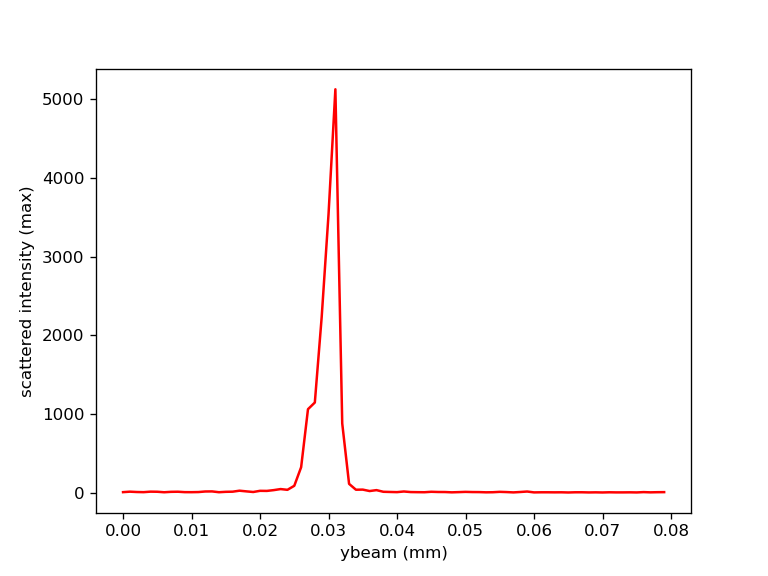

<IPython.core.display.Javascript object>


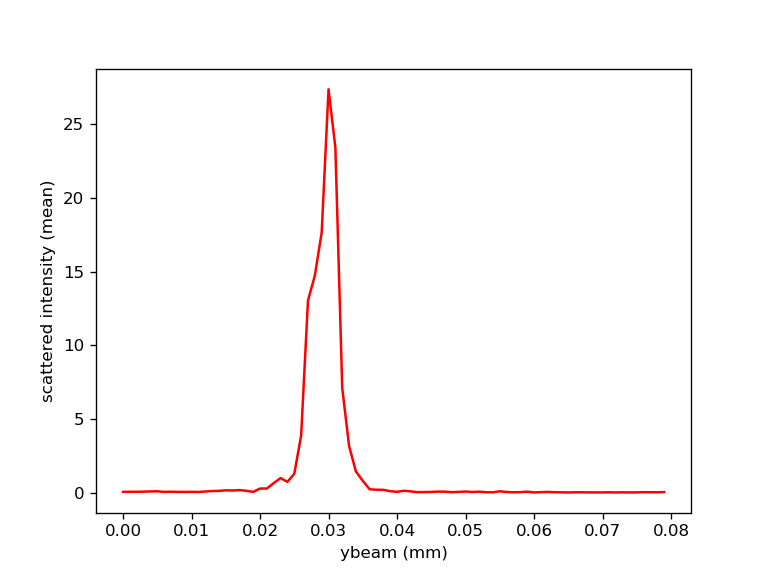

Text(0,0.5,'scattered intensity (mean)')

In [36]:
#----------- AFTER reconstruction -----------
fig = mplp.figure()
mplp.plot(depth, np.max(recspot, axis=(0,1,)), 'r')
ax = fig.gca()

ax.set_xlabel('ybeam (mm)')
ax.set_ylabel('scattered intensity (max)')


fig2 = mplp.figure()
mplp.plot(depth, np.mean(recspot, axis=(0,1,)), 'r')
ax2 = fig2.gca()
ax2.set_xlabel('ybeam (mm)')
ax2.set_ylabel('scattered intensity (mean)')


<IPython.core.display.Javascript object>


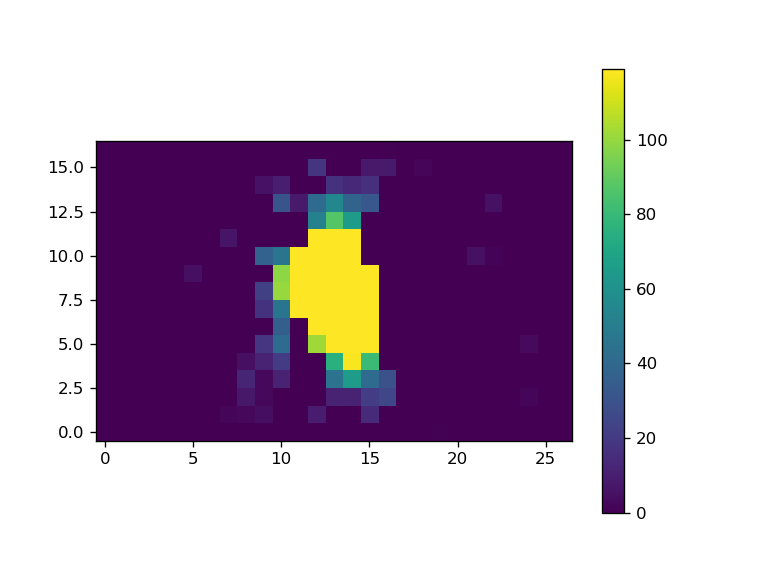

interactive(children=(IntSlider(value=0, description='idx', max=79), Output()), _dom_classes=('widget-interact…

<IPython.core.display.Javascript object>


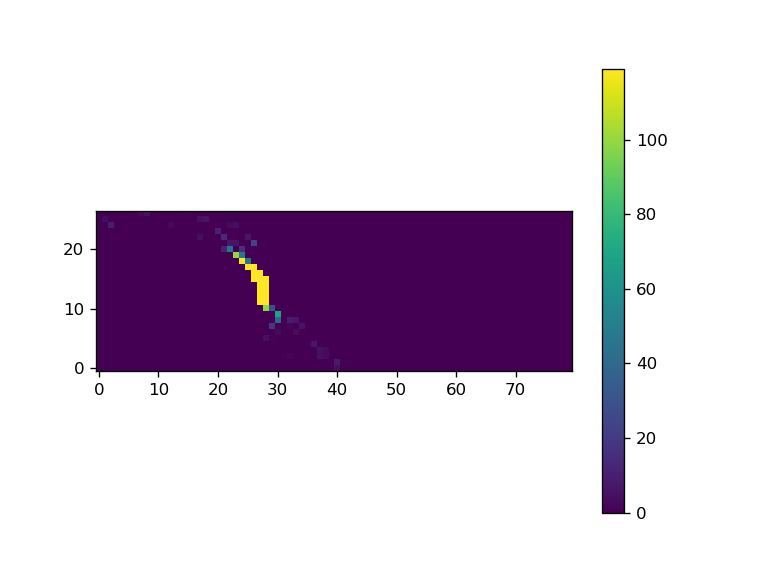

interactive(children=(IntSlider(value=0, description='idx', max=16), Output()), _dom_classes=('widget-interact…

<IPython.core.display.Javascript object>


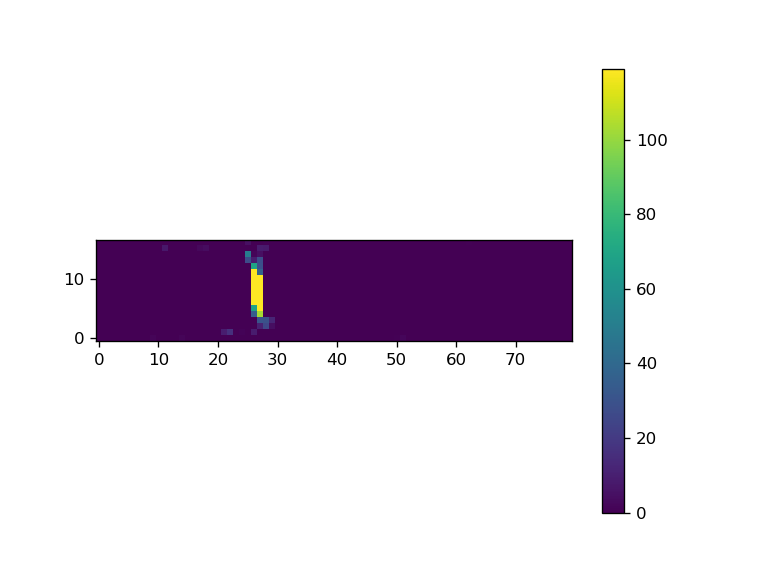

interactive(children=(IntSlider(value=0, description='idx', max=26), Output()), _dom_classes=('widget-interact…

<function __main__.fig_slider.<locals>.update_img(idx)>

In [31]:
# vertical = horizontal pixel 2*halfboxsize[0] ,  horizontal = vertical 2*halfboxsize[1] pixel
# slider     idx  = micron  drange narrow
fig_slider(recspot)

# vertical  pixel  2*halfboxsize[1], horizontal idx  = micron  drange narrow

fig_slider(recspot, axis=0)

# horizontal  pixel  2*halfboxsize[0], horizontal idx  = micron  drange narrow

fig_slider(recspot, axis=1)


In [32]:
print('drange_large=',drange_large)
print('drange_narrow=',drange_narrow)

drange_large= [0.0, 0.08]
drange_narrow= [0.0, 0.08]
